# Clustering
Unsupervised machine learning. Discrete classification. 

Links: [Tutorial](https://matteucci.faculty.polimi.it/Clustering/tutorial_html/index.html) from Italy.
[sklearn](https://scikit-learn.org/stable/modules/clustering.html) index of all algorithms.
[sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) comparison on toy datasets.

Clustering metrics: 
* single-linkage clustering (min)
* complete-linkage clustering (max)
* average-linkage clustering
* sum of squared Euclidean distances from the cluster mean (centroid) 

## Ward's Method
Also called minimum-variance, Ward's method is very popular. 
Ward described clustering as minimizing an objective function.
He gave an example function that is now called Ward's Linkage.
[Wikipedia](https://en.wikipedia.org/wiki/Ward%27s_method)

Use agglomerative hierarichal clustering.
Start with each point a cluster.
Join two clusters that minimize the increase in within-cluster variance. 
Overall, minimize the SSE i.e. sum of the Euclidean distances squared.

Ward's is similar to ANOVA which also measures SSE of within-group variance. 

Whereas K-means sums distances of all points to a centroid (point in space),
Ward sums distances of points to each other.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
#np.random.seed(0)

## Hierarchical clustering
### Agglomerative clustering
Bottom-up. Scales well. Works with any distance metric, even non-Euclidean ones. Can choose #clusters interactively.  

SciKit-Learn tools: 
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) AgglomerativeClustering. You can set the stopping criteria by #clusters or a distance threshold. You can access attributes like #clusters, #leaves, #features used, and #connected components.    
* [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html#sklearn.cluster.FeatureAgglomeration) FeatureAgglomeration can cluster features for dimensionality reduction.

In [2]:
# Here are some standard data sets.
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Here are some nice colors for showing clusters
COLORS = np.array(["#377eb8","#ff7f00","#4daf4a","#f781bf","#a65628","#984ea3","#999999","#e41a1c","#dede00"])

In [3]:
# Simple wrapper for AgglomerativeClustering.
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.AgglomerativeClustering()
    if num_clusters is not None:
        alg = cluster.AgglomerativeClustering(num_clusters)  
        ## with no setting, it converges on 2
    alg.fit(X)
    ypred = alg.labels_
    print('#clusters',alg.n_clusters_,'cluster assignments per point',alg.labels_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

#clusters 2 cluster assignments per point [1 1 1 0 0 0]


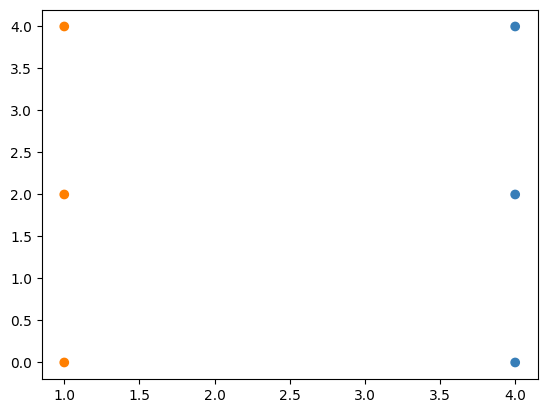

In [4]:
# This simple example demonstrates success.
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
Y = [0,0,0,1,1,1]
make_clusters( (X,Y) )

#clusters 2 cluster assignments per point [0 0 1 ... 1 1 0]


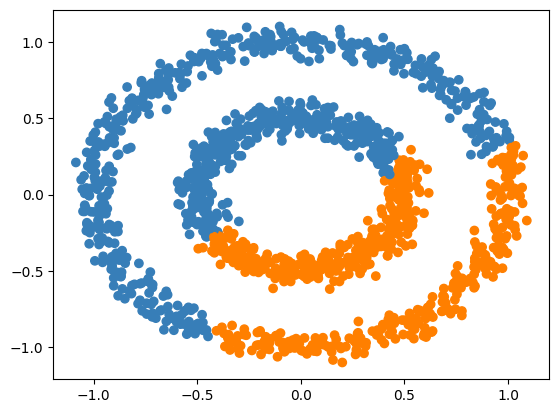

In [5]:
# This failed example demonstrates risk of using Euclidean distance.
make_clusters(noisy_circles)

#clusters 3 cluster assignments per point [2 2 2 ... 2 1 1]


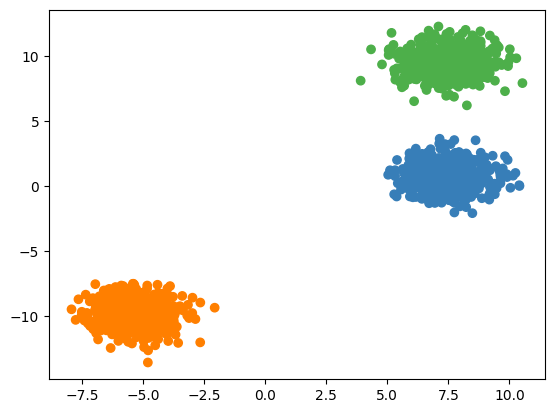

In [6]:
# This example shows success with K=2 or K=3.
make_clusters(blobs,3)  

#clusters 5 cluster assignments per point [2 3 2 ... 1 2 4]


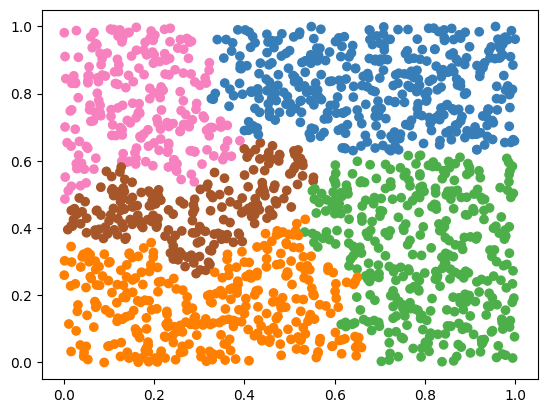

In [7]:
# When the data don't have natural clusters,
# the algorithm might partition the data into equal-size clusters.
make_clusters(no_structure,5)

## K-Means Clustering  
This is one kind of partition clustering.

Objective is to minimimize sum of squared norms of deviations from the cluster mean. The norm is usually Euclidean disatance.

Easy to use. Fast. K is a parameter.
Note the means are points in space not data instances.
This makes the algorithm sensitive to outliers.
The computation can fail on singularities induced by 
cluster size 1 (zero variance) or cluster size 0.
The algorithm performs poorly when clusters have
dissimilar size or shape. 
(Recommend preprocess such as achieving uniform SSE.)

K-means is heuristic. 
K-means is not optimal; it finds a local optimum. 
In particular, once it merges two real clusters,
those clusters will never separate.
We use some stopping criteria when results are good enough.

K-means is an expectation maximization algorithm.
K-means uses discrete EM: each data point belongs to one cluster.
Classic EM is continuous: each data point is partially explained by each cluster.

The cluster assignment in K-means is a Voronoi tesselation.
As such, the choice of distance metric matters: 
Manhattan, Euclidean, cosine, correlation, Hamming (for bit vectors).
Some require normalizing points to zero mean, unit standard deviation.

For continuous data, use means.
For categorical data, use modes.
For tighly clumped data, use centroids (points in space).
For dispersed data, use medoids (actual data points).

The choice of K is heuristic, but here are some aids. 
* Information criteria (using a likelihood function): BIC, AIC, DIC.
* Calinksi-Harabasz or Davies-Bouldin Criterion use 
between vs within variance after trying multiple K.

We cannot simply minimize within-group variance.
The more clusters, the lower the variance.
At N clusters for N data points, variance is zero.

The algorithm is sensitive to the initial means.
It is recommended to try several reruns with different random initializers.
Kmeans++ is a way to choose better initializers.
It chooses random points that are not close to each other
and are reflective of the data distributon.
Kmeans++ has guarrantee of coming within log() of the optimum.
The algorithm was in a tech note [Kmeans++](http://ilpubs.stanford.edu:8090/778/1/2006-13.pdf)
from Stanford! 
Another way to improve initializers is to start with large K,
Choose the K random points, 
then remove points that are closest to other points.

K-means algorithms:
* Lloyd. This is the standard algorithm. 
On every iteration, it recomputes the Euclidean distance 
between every data point and every mean.
* Elkan. The Elkan optimization uses triangle inequality between triplets
to avoid some recomputes. 
(The explanation is complicated. Here is my oversimiplified guess.
Say points 1 and 2 were not assigned to cluster X, and
point 1 was even further than point 2 from mean X. 
Assume mean X moved just a little on this iteration.
If you determine that point 2 is still not going to join cluster X,
you are fairly certain point 1 won't join cluster X either.)

SciKit-Learn:
* [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans).
The sklearn class runs K-means 10 times (settable) 
on different initializers.
The initializer parameter can be 'random', 'kmeans++',
or an array of means & weights.
Using random is fastest but gives worst results. 
The weights give the means different amounts of inertia,
so the heaviest mean is least likely to move a lot.
* The algorithm is settable: Lloyd or Elkan (see my text above).
* For large data, use sklearn [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html#sklearn.cluster.MiniBatchKMeans). 
This re-estimates means on small batches rather than all the data.

Links: Caltech lecture [Ciro Donalek](https://youtu.be/YifY5uVRWTk)

## Evaluating clusters
Method 1, using labeled data.
Plot values of K on the X-axis. 
Plot the SSE on the Y-axis. 
Choose K near an elbow.

Method 2, using unlabeled data.
This is called Silhouette, a term for describing knife blades.
A(i) = average distance from i to other points in this cluster.
B(i) = minimum average distance from this cluster to all others.
S(i) = (B - A)/max(A,B).
Normalize +1 to -1.
Thus, +1 means like this cluster and unlike any other cluster.

Within one cluster, sort from max to min.
Visualize as horizontal bar chart, forming knife edges.
Butcher's knives (dull point because most bars are near 1) 
indicate better clusters than paring knives (sharp point because only 1 bar is long).


In [8]:
# Simple wrapper for Kmeans.
def make_clusters(XY, num_clusters=None):
    X = XY[0]
    Y = XY[1]
    alg = cluster.KMeans()  # default = 8
    if num_clusters is not None:
        alg = cluster.KMeans(num_clusters)  
    alg.fit(X)
    ypred = alg.labels_
    print('iterations',alg.n_iter_,',cluster centers:\n',alg.cluster_centers_)
    print('cluster assignments per point',alg.labels_)
    print('SSE (optionally weighted)',alg.inertia_)
    plt.scatter(X[:, 0], X[:, 1], color=COLORS[ypred])
    plt.show()

iterations 11 ,cluster centers:
 [[0.23312969 0.77065878]
 [0.78884543 0.20496336]
 [0.22831108 0.23872359]
 [0.77666015 0.79772995]
 [0.56629572 0.47204157]]
cluster assignments per point [4 0 3 ... 2 3 4]
SSE (optionally weighted) 52.17503680042461


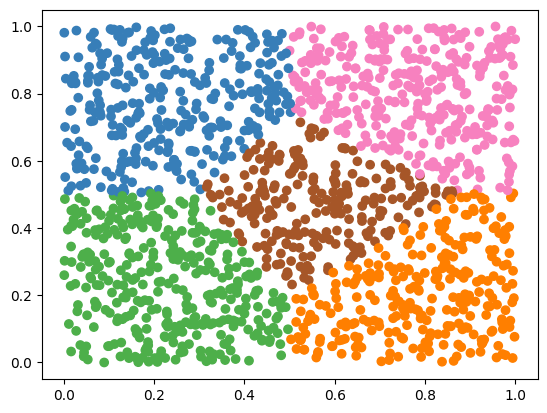

In [9]:
# When the data has no natural clusters,
# K-means might partion the data into equal size clusters.
# We will try K=5 and K=6 on same data.
make_clusters(no_structure,5)

iterations 17 ,cluster centers:
 [[0.26381746 0.81623783]
 [0.5618655  0.47154755]
 [0.31189249 0.13097303]
 [0.81906011 0.22945483]
 [0.78305855 0.79869103]
 [0.16002323 0.42985631]]
cluster assignments per point [1 0 3 ... 2 4 1]
SSE (optionally weighted) 43.33354763500465


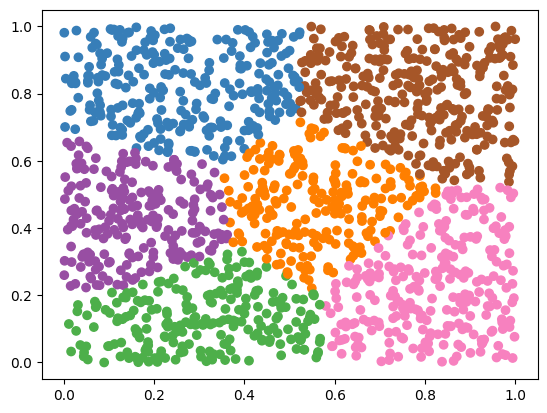

In [10]:
# Same as above with K=6.
make_clusters(no_structure,6)

## Bisecting Kmeans
This is another partition clustering algorithm.

This algorithm starts with one cluster
then iteratively cut one cluster into 2 (or into n). 
There are various strategies for choosing the next cluster to split.
This algorithm never generates empty clusters. 
You can't use this on K=2.

This is faster than Kmeans because it operates on data subsets,
so this is preferred on big data.
Compared to Kmeans with random initializers,
this is more likely to discover the data's natural hierarchy, and
less likely to generate a cluster of unrelated points.
However, this underperforms compared to 
Kmeans with Kmeans++ initializer.

SciKit-Learn:
* [BisectingKmeans](https://scikit-learn.org/dev/modules/generated/sklearn.cluster.BisectingKMeans.html)
is not yet released.
For now, you must install developer pre-release, ver 1.1. 
* This class has the same fields and methods as Kmeans. 
* You can set the bisection strategy to 
always choose the cluster with max(#points) or max(SSE). 
See [sklearn](https://scikit-learn.org/dev/auto_examples/cluster/plot_bisect_kmeans.html) to compare Kmeans with Bisecting Kmeans.

# Implement K-means from scratch.
For deeper understanding, we implement Kmeans from scratch.
To keep it simple, use only one feature i.e. one dimension.
The algorithm must slide the means left & right to find optimal.

Implementing our code, we compute and display SSE
to show that it reduces as the means approach 20 and 40. 
However, our topping criteria was delta mean, not SSE.

Testing our code, we found the initializers made a big difference.
The code often generated poor results when given bad initial values.

This code is designed for K=2. 
That simplifies the situation.
We only need to test two means for each point's cluster membership.
The distance calculation is scalar not vector.

This code is designed for #features=1.
That simplifies the situation.
Each distance from the mean is computed by 
simple subtraction along X axis.
For additional features, each point and mean would be a vector.
We would use element-wise subtraction to determine convergence, 
and norm=np.linalg.norm(diff)
i.e. sqrt of sum of squares of differences per dimension.

Our code can crash on divide by zero,
but this only happens with bad initial guesses 
outside the acutal (random) data range, such as
(0,0) or (0,1) or (1,2) or (100,200).
We saw fast convergence with parameters near the extremes
such as (10,50) .
We saw eventual convergence with means like 
(20,21) or (40,41) or (60,61).

In [11]:
def distance(p1,p2):
    # Compute the norm of the distance between points p1 and p2.
    # For single-feature data, all the norms are equivalent.
    # For Kmeans in higher dimensions, the L2 norm is used.
    # Althouth L1 is simply abs(p1-p2),
    # and sqrt of square is a wasteful identity op,
    # we'll use L2 to be pedantic.
    return np.sqrt((p1-p2)**2)
def is_closer(point,this_mean,that_mean):
    return distance(point,this_mean) < distance(point,that_mean)
def sse(vector,mean):
    err=vector-mean
    se=np.square(err)
    sse=sum(se)
    return int(sse)
def assign_clusters(mean1,mean2,data):
    clust1=np.asarray([x for x in data if is_closer(x,mean1,mean2)])
    clust2=np.asarray([x for x in data if is_closer(x,mean2,mean1)])
    print('Cluster sizes:',len(clust1),len(clust2))
    return clust1,clust2
def recompute_means(clust1,clust2):
    mean1=np.mean(clust1)
    mean2=np.mean(clust2)
    print('New means: %.2f %.2f' % (mean1,mean2) )
    return mean1,mean2
def compute_sse(clust1,clust2,mean1,mean2):
    sse1=sse(clust1,mean1)
    sse2=sse(clust2,mean2)
    print('Cluster SSE: %d %d' % (sse1,sse2) )
    print('Cluster stdev: %.2f %.2f' % (
        np.sqrt(sse1)/len(clust1),
          np.sqrt(sse2)/len(clust2)))  
    return sse1,sse2
def iterative_2_means_delta(mean1,mean2,data,delta):
    """Iterate till the means change by less than delta."""
    clust1,clust2=assign_clusters(mean1,mean2,data)
    sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
    prev_SSE = sse1 + sse2
    diff = None
    while diff is None or diff>delta:
        print()
        mean1,mean2=recompute_means(clust1,clust2)
        clust1,clust2=assign_clusters(mean1,mean2,data)
        sse1,sse2 = compute_sse(clust1,clust2,mean1,mean2)
        this_SSE = sse1 + sse2
        diff = prev_SSE - this_SSE
        print('Diff:',diff,'Delta:',delta)
        prev_SSE = this_SSE
    return clust1,clust2

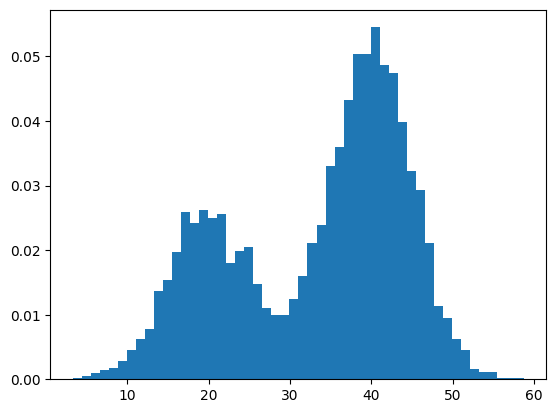

In [12]:
# Use data suggested by the Mastery site.
# Construct a bimodal from two Gaussian processes.
# Can K-means with K=2 reconstruct the 2 means?
from numpy import hstack
from numpy.random import normal
from matplotlib import pyplot
# normal ( mean, standard deviation, count )
def plot(X1,X2):
    X = hstack( (X1, X2) )  # horizontal stack i.e. concat
    pyplot.hist(X, bins=50, density=True)
    pyplot.show()
X1 = normal(loc=20, scale=5, size=3000) 
X2 = normal(loc=40, scale=5, size=6000)
plot(X1,X2)

In [13]:
# Choose not-quite-random initializers, k=2.
guess1 = 5
guess2 = 10
X = hstack( (X1, X2) ) 
X = X.reshape((len(X), 1))
X = np.asarray(X)
print('Initial means:',guess1,guess2)
new1,new2=iterative_2_means_delta(guess1,guess2,X,0.01)

Initial means: 5 10
Cluster sizes: 26 8974
Cluster SSE: 66 5938738
Cluster stdev: 0.31 0.27

New means: 6.12 33.42
Cluster sizes: 1462 7538
Cluster SSE: 150635 567532
Cluster stdev: 0.27 0.10
Diff: 5220637 Delta: 0.01

New means: 15.81 36.75
Cluster sizes: 2710 6290
Cluster SSE: 78238 236072
Cluster stdev: 0.10 0.08
Diff: 403857 Delta: 0.01

New means: 19.01 39.52
Cluster sizes: 2996 6004
Cluster SSE: 72178 147465
Cluster stdev: 0.09 0.06
Diff: 94667 Delta: 0.01

New means: 19.84 40.08
Cluster sizes: 3060 5940
Cluster SSE: 76227 138533
Cluster stdev: 0.09 0.06
Diff: 4883 Delta: 0.01

New means: 20.05 40.20
Cluster sizes: 3071 5929
Cluster SSE: 77200 137325
Cluster stdev: 0.09 0.06
Diff: 235 Delta: 0.01

New means: 20.08 40.21
Cluster sizes: 3072 5928
Cluster SSE: 77297 137222
Cluster stdev: 0.09 0.06
Diff: 6 Delta: 0.01

New means: 20.09 40.22
Cluster sizes: 3072 5928
Cluster SSE: 77297 137222
Cluster stdev: 0.09 0.06
Diff: 0 Delta: 0.01


## Mean Shift Segmentation
Process every data point once.
Find K cluster representatives, 
and assign every data point to its cluster representative,
by hill climbing. 
For hill climbing, start with a circle around the data point,
find the center of mass, and recenter at nearest data point.
Repeat until change is less than threshold.

The main parameter is bandwidth
i.e. the diameter of circle around each point.
Other parameters are threshold (stopping criteria)
and kernel.
For flat kernel, consider all points equally for center of mass.
For gaussian kernel, weight closer points more.

## Self-organizing Maps (SOM)
Map high dimensional data to a lower dimensional map.
The map will preserve distances such that clusters remain clusered.
The mapping will not identify the clusters
but it will make them easier to find or visualize.

Define the grid. 
Usually use a 2D grid that is 
rectangular (every point has 8 neighbors)
or hexogonal (every point has 6 neighbors).
Choose K, the number of units on the grid.
Initialize each unit with
(grid space attribute 1) its position on the 2D grid, 
(feature space attribute 2) an initial cluster representative.
The feature space attributes are also called the weights
or the prototype vectors.

The initial feature space attributes can be random values,
random samples from the data,
or intelligently distributed values e.g. 
sampled along the data's principal eigenvectors.
Best results if training starts with a good map.

Define neighborhood radius within the grid space. 
When neighborhood includes only self, 
then the algorithm reduces to K-means.
If neighborhood includes only direct neighbors,
then neighborhoods have size 9 (rectangular) or 7 (hexogonal).
If neighborhoods are larger,
then use a gaussian kernel to weight neighbors by distance.

Map a data point (input vector) to all units' 
feature space vectors (prototype vectors).
The data point will be closest to one unit.
(The mapping is often drawn as between 4 units,
but this is only true of the map is close to finished.)
For each data point, finding its closest Best Matching Unit (BMU)
defined as minimal distance in feature space.
In each epoch, process every data point.

Select the BMU neighborhood in grid space.
For each unit in the neighborhood,
adjust its feature space attributes to match the data point.
The BMU will adjust the most.
The immediate neighbors will adjust less.
The distant neightbors will adjust the least.

Update rule:  
$w_i(t+1)=w_i(t)+A_t*H_t(i,bmu(x))*[x-w_i(t)]$  
where $x$ is the data point proccessed at time $t$ 
and $bmu(x)$ is its best matching unit,
$i$ is the unit whose weight $w_i$ we are updating,
$A_t$ is the learn rate,
and $H_t$ is the neighborhood proximity function.
Both A and H can be decreasing over time.

After training, natural clusters in the data
will induce corresponding clusters in the map.
The SOM does not define the custer representatives
but the SOM can be used for visualization and analysis.
In a hit heatmap, each unit's heat represents BMU count
(and colors could represent ground truth if known).
Heatmap based on individual featues show component planes,
and these can show correlations visually.
Relative importance heatmap shows features most correlated
to regions of the map.

Quantization error measures distance of each data point to its BMU.
Topographic error measures portion of 2nd-best units that are not adjacent to the BMU.
Movies can show a data point's trajectory through SOM over time.

SciKit-Learn has no SOM implementation.
Confusingly, some Bozo named his tool [sklearn-som](https://github.com/rileypsmith/sklearn-som).